In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
import glob
import re

# Set plotting style
plt.style.use('ggplot')
sns.set_palette('husl')


In [ ]:
# Loading Datasets
sample_path = r'../sample_output/new_product.csv'
dataset_path = r'../dataset/Amazon-Products.csv'

df_sample = pd.read_csv(sample_path)
df = pd.read_csv(dataset_path)

print("--- Source Data Info ---")
df.info()
print("\n--- Sample Target Info ---")
df_sample.info()


--- Source Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      551585 non-null  int64 
 1   name            551585 non-null  object
 2   main_category   551585 non-null  object
 3   sub_category    551585 non-null  object
 4   image           551585 non-null  object
 5   link            551585 non-null  object
 6   ratings         375791 non-null  object
 7   no_of_ratings   375791 non-null  object
 8   discount_price  490422 non-null  object
 9   actual_price    533772 non-null  object
dtypes: int64(1), object(9)
memory usage: 42.1+ MB

--- Sample Target Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51444 entries, 0 to 51443
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     5144

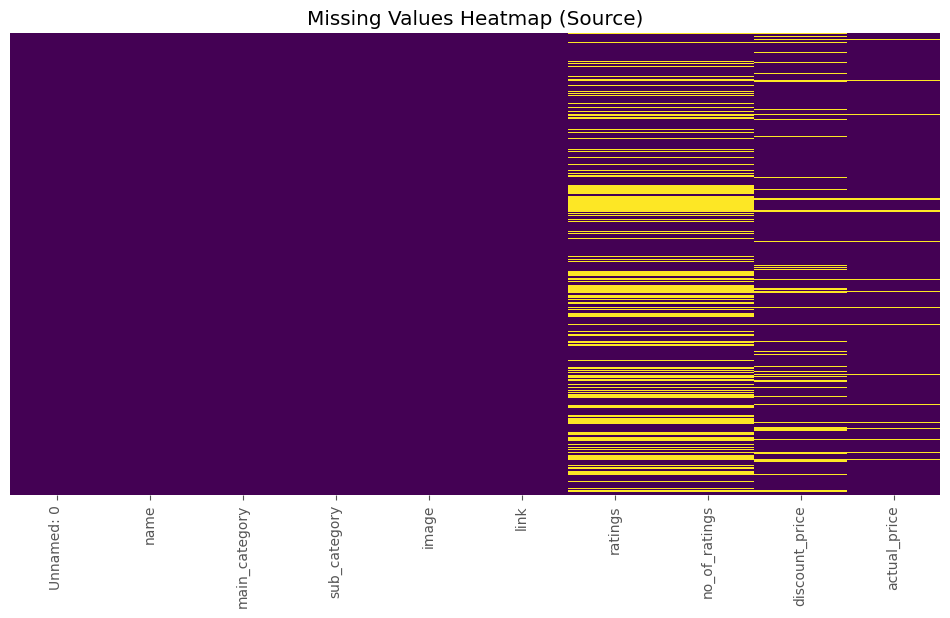

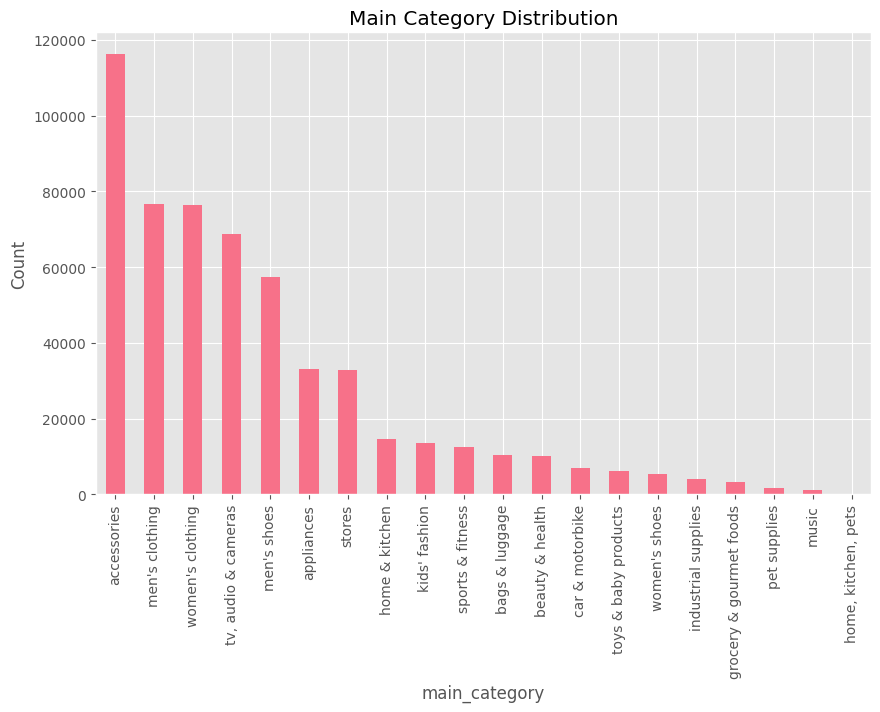

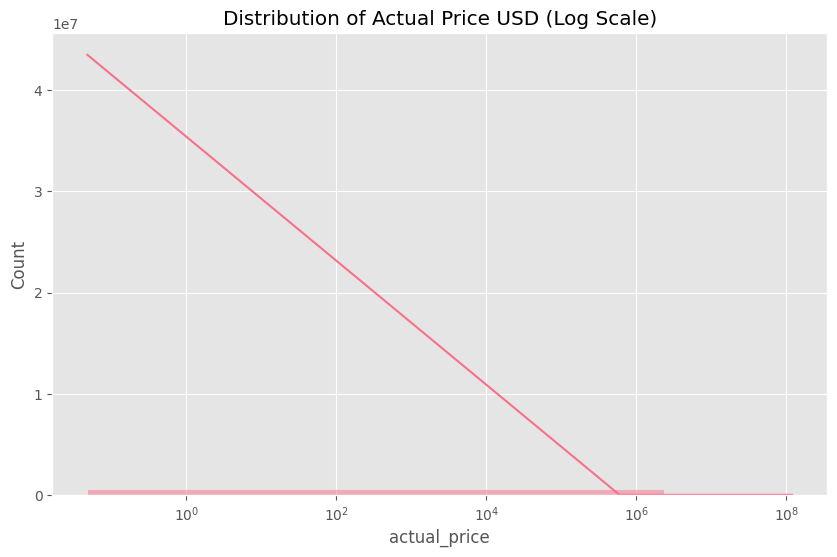

In [ ]:
# Initial EDA (Before Cleaning)

# 1. Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Source)')
plt.show()

# 2. Categorical Distribution
plt.figure(figsize=(10, 6))
df['main_category'].value_counts().plot(kind='bar')
plt.title('Main Category Distribution')
plt.ylabel('Count')
plt.show()

# Helper to clean initial numeric strings for EDA
def quick_clean(val):
    if pd.isna(val) or val == '': return 0
    val = str(val).replace('₹', '').replace(',', '')
    try: return float(val)
    except: return 0

temp_actual = df['actual_price'].apply(quick_clean) * 0.012

# 3. Price Histogram (Initial Log Scale)
plt.figure(figsize=(10, 6))
sns.histplot(temp_actual[temp_actual > 0], bins=50, kde=True)
plt.xscale('log')
plt.title('Distribution of Actual Price USD (Log Scale)')
plt.show()


In [ ]:
# Cleaning & Strict Filtering

# 1. Currency Conversion (INR to USD ~0.012)
def clean_price_usd(x):
    if pd.isna(x) or x == '': return 0.0
    res = str(x).replace('₹', '').replace(',', '')
    try:
        return round(float(res) * 0.012, 2)
    except:
        return 0.0

df['discount_price_usd'] = df['discount_price'].apply(clean_price_usd)
df['actual_price_usd'] = df['actual_price'].apply(clean_price_usd)

# 2. Quality Filtering
# Remove zero prices
df = df[(df['discount_price_usd'] > 0) & (df['actual_price_usd'] > 0)]

# Clean no_of_ratings
def clean_ratings_count(x):
    if pd.isna(x) or x == '': return 0.0
    res = str(x).replace(',', '')
    try: return float(res)
    except: return 0.0

df['no_of_ratings'] = df['no_of_ratings'].apply(clean_ratings_count)

# Clean ratings
def clean_ratings(x):
    if pd.isna(x) or x == '' or x == 'Get': return 0.0
    try: return float(x)
    except: return 0.0

df['ratings'] = df['ratings'].apply(clean_ratings)

# Filter: Remove ratings = 0 or no_of_ratings = 0
df = df[(df['ratings'] > 0) & (df['no_of_ratings'] > 0)]

# 3. Price Bracketing ($1.00 - $10,000)
df = df[(df['actual_price_usd'] >= 1.0) & (df['actual_price_usd'] <= 10000.0)]

# 4. Deduplication by Name
initial_count = len(df)
df = df.drop_duplicates(subset=['name'])
print(f"Removed {initial_count - len(df)} duplicate products by name.")


Removed 97586 duplicate products by name.


In [ ]:
# Feature Engineering

# 1. Label Encoding (Starting from 0)
le_main = LabelEncoder()
df['main_category_encoded'] = le_main.fit_transform(df['main_category'])

le_sub = LabelEncoder()
df['sub_category_encoded'] = le_sub.fit_transform(df['sub_category'])

# 2. Unique ID Generation
# Create a prefix mapping
prefixes = {cat: cat[:3].lower() for cat in df['main_category'].unique()}
df['cat_prefix'] = df['main_category'].map(prefixes)

# Sequential number within entire dataframe
df = df.reset_index(drop=True)
df['id'] = df['cat_prefix'] + df.index.map(lambda x: f"{x:06d}")

# Final Column Selection & Order
final_cols = [
    'id', 'name', 'main_category', 'main_category_encoded',
    'sub_category', 'sub_category_encoded', 'image', 'link',
    'ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd'
]
df_final = df[final_cols]


--- Final Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237130 entries, 0 to 237129
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     237130 non-null  object 
 1   name                   237130 non-null  object 
 2   main_category          237130 non-null  object 
 3   main_category_encoded  237130 non-null  int64  
 4   sub_category           237130 non-null  object 
 5   sub_category_encoded   237130 non-null  int64  
 6   image                  237130 non-null  object 
 7   link                   237130 non-null  object 
 8   ratings                237130 non-null  float64
 9   no_of_ratings          237130 non-null  float64
 10  discount_price_usd     237130 non-null  float64
 11  actual_price_usd       237130 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 21.7+ MB

--- Descriptive Statistics ---
       main_category_enco

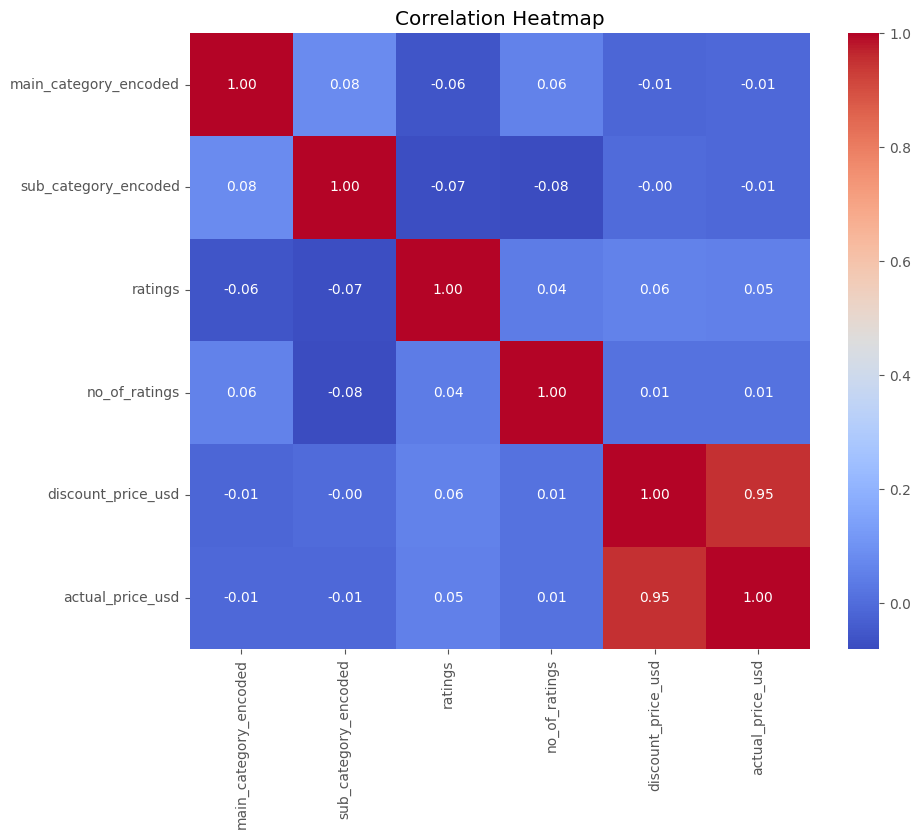

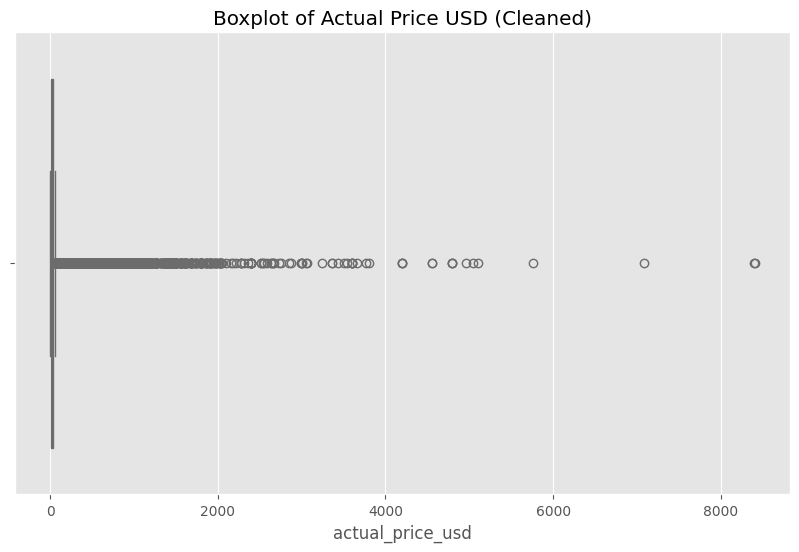

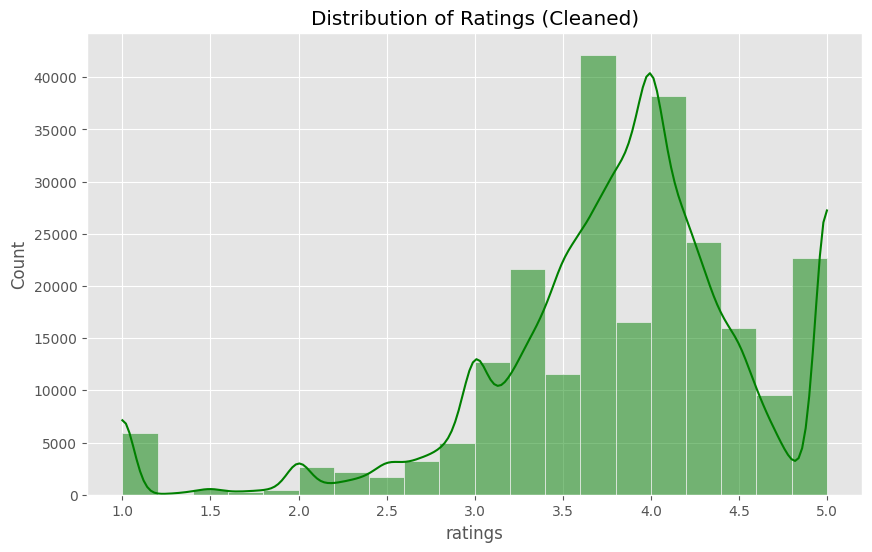

In [ ]:
# Post-Processing Visualization

print("--- Final Dataset Info ---")
df_final.info()
print("\n--- Descriptive Statistics ---")
print(df_final.describe())

# 1. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 2. Price Boxplot (Cleaned)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['actual_price_usd'])
plt.title('Boxplot of Actual Price USD (Cleaned)')
plt.show()

# 3. Final Ratings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['ratings'], bins=20, kde=True, color='green')
plt.title('Distribution of Ratings (Cleaned)')
plt.show()


In [ ]:
# Final Export (Auto-increment logic)

output_dir = r'../pre_processing'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

base_filename = 'Amazon-Products_processed'
existing_files = glob.glob(os.path.join(output_dir, f"{base_filename}_*.csv"))

numbers = [0]
for f in existing_files:
    match = re.search(r'_(\d+)\.csv$', f)
    if match:
        numbers.append(int(match.group(1)))

next_num = max(numbers) + 1
output_filename = f"{base_filename}_{next_num:02d}.csv"
output_path = os.path.join(output_dir, output_filename)

df_final.to_csv(output_path, index=False)
print(f"✅ Refined dataset saved to: {output_path}")
print(f"Final Row Count: {len(df_final)}")


✅ Refined dataset saved to: ../pre_processing\Amazon-Products_processed_03.csv
Final Row Count: 237130
